<a href="https://colab.research.google.com/github/VenomCocytus/IMDB_Sentimental_Analysis_Python/blob/main/CNN_with_LSTM_classifier_for_Sentimantal_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load dependencies

In [2]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM
from tensorflow.keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd

# Set Hyperparameters

In [3]:
# Model Train
epochs = 10
batch_size = 128

# Vector space embedding
n_dim = 64
n_unique_words = 5000
max_review_length = 100
pad_type = trunc_type = 'pre'
drop_embed = 0.2

# CNN architecture
n_conv = 256
k_conv = 3

#Dense Layer architecture
n_dense = 256
dropout = 0.2

# Load Data

In [4]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words = n_unique_words)

# Data Pre-processing

In [5]:
x_train = pad_sequences(x_train, maxlen = max_review_length, padding = pad_type, truncating = trunc_type, value = 0)
x_valid = pad_sequences(x_valid, maxlen = max_review_length, padding = pad_type, truncating = trunc_type, value = 0)

# CNN Design Architecture

In [6]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length = max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(n_conv, k_conv, activation = 'relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(n_dense, activation = 'relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation = 'sigmoid'))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           320000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 64)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 98, 256)           49408     
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0

# Configure Model

In [8]:
model.compile(loss = 'binary_crossentropy', optimizer = 'nadam', metrics = ['accuracy'])

# Train Model

In [14]:
es = EarlyStopping(monitor = 'val_accuracy', mode = 'max', min_delta = 0.01, patience = 4, verbose = 1, restore_best_weights = True)

In [10]:
model_log = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, verbose = 1, validation_data = (x_valid, y_valid), callbacks=[es])

Epoch 1/10
196/196 [==============================] - 34s 170ms/step - loss: 0.5089 - accuracy: 0.7289 - val_loss: 0.3536 - val_accuracy: 0.8395
Epoch 2/10
196/196 [==============================] - 33s 168ms/step - loss: 0.3112 - accuracy: 0.8683 - val_loss: 0.3404 - val_accuracy: 0.8509
Epoch 3/10
196/196 [==============================] - 26s 132ms/step - loss: 0.2364 - accuracy: 0.9054 - val_loss: 0.3270 - val_accuracy: 0.8590
Epoch 4/10
196/196 [==============================] - 26s 132ms/step - loss: 0.1783 - accuracy: 0.9325 - val_loss: 0.3462 - val_accuracy: 0.8579
Epoch 5/10
196/196 [==============================] - 27s 137ms/step - loss: 0.1297 - accuracy: 0.9533 - val_loss: 0.6803 - val_accuracy: 0.7808
Epoch 6/10
196/196 [==============================] - 27s 139ms/step - loss: 0.0862 - accuracy: 0.9720 - val_loss: 0.4548 - val_accuracy: 0.8486
Epoch 6: early stopping


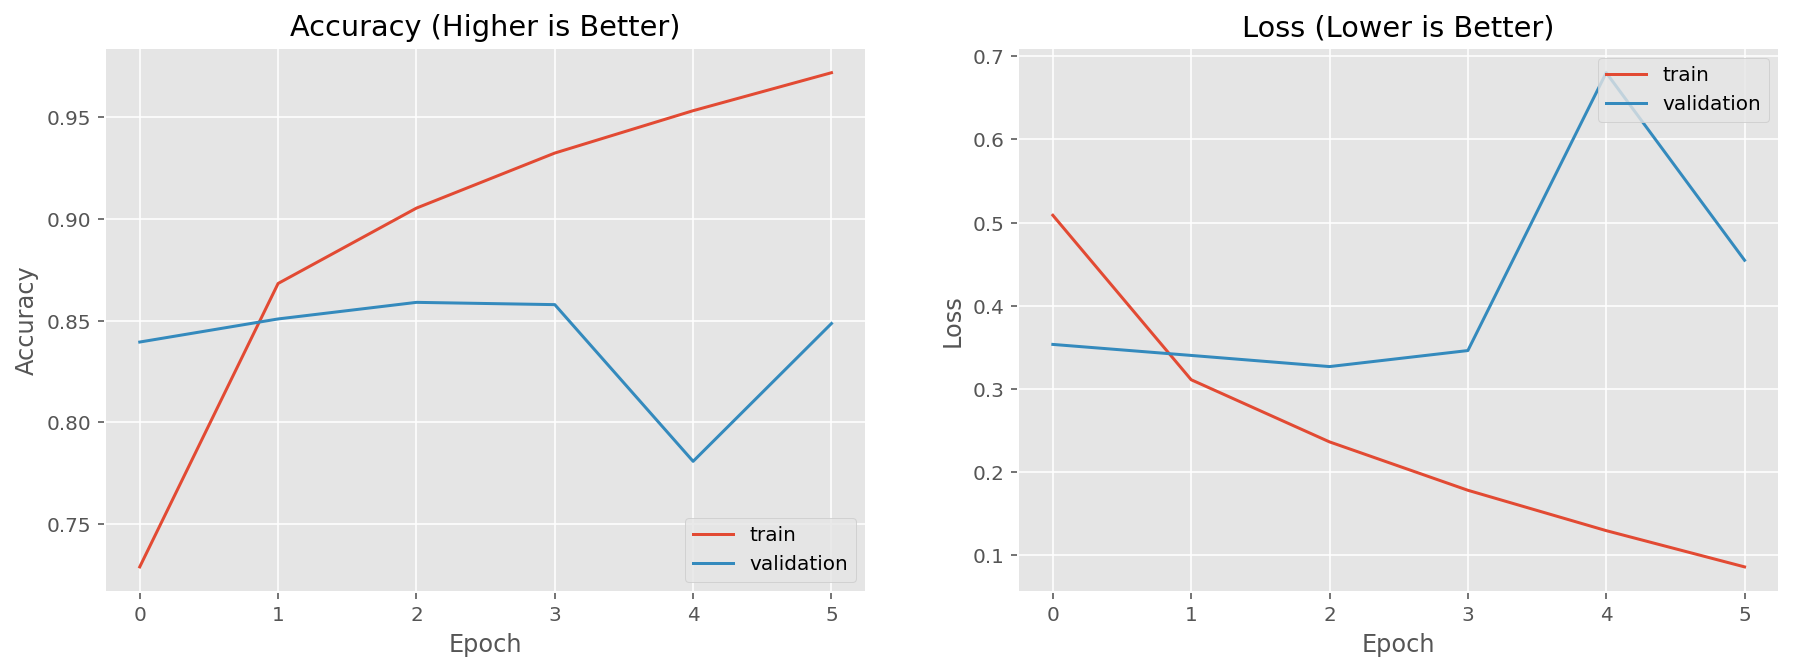

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))

ax1.plot(model_log.history['accuracy'])
ax1.plot(model_log.history['val_accuracy'])
ax1.set_title('Accuracy (Higher is Better)')
ax1.set(xlabel = 'Epoch', ylabel = 'Accuracy')
ax1.legend(['train', 'validation'], loc = 'lower right')

ax2.plot(model_log.history['loss'])
ax2.plot(model_log.history['val_loss'])
ax2.set_title('Loss (Lower is Better)')
ax2.set(xlabel = 'Epoch', ylabel = 'Loss')
ax2.legend(['train', 'validation'], loc = 'upper right')
ax2.xaxis.set_major_locator(MaxNLocator(integer = True ))

In [17]:
model.save("IMDBCNN&LSTMmodel.h5")

In [18]:
score = model.evaluate(x_valid, y_valid, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy', score[1])

Test loss: 0.3403789699077606
Test accuracy 0.8508800268173218


In [20]:
y_hat = model.predict(x_valid)
y_hat1 = pd.DataFrame(data = y_hat)
y_hat1[0]=y_hat1[0].apply(lambda a:0 if a<=0.5 else 1)
y_hat2 = y_hat1[0]

In [21]:
print(confusion_matrix(y_valid, y_hat2))
print(classification_report(y_valid, y_hat2))

[[ 9758  2742]
 [  986 11514]]
              precision    recall  f1-score   support

           0       0.91      0.78      0.84     12500
           1       0.81      0.92      0.86     12500

    accuracy                           0.85     25000
   macro avg       0.86      0.85      0.85     25000
weighted avg       0.86      0.85      0.85     25000

